Savin, Nikitina, Dubenskiy

Romanenko project

<font color="green"> 1.1 and 1.2 are done here </font>

<span style="color:black; font-size: 12pt"></span>


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# don't forget to upload utils file to the colab session
import warnings

warnings.filterwarnings('ignore')

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

import warnings
warnings.filterwarnings('ignore')

# # setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
# import seaborn as sns
# sns.set_style("darkgrid")
# pd.plotting.register_matplotlib_converters()
# # Default figure size
# sns.mpl.rc("figure", figsize=(25, 5))
# sns.mpl.rc("font", size=14)

# I. Building Time Series Forecastability Index
Those Time Series that have about the same accuracy level should have the same $\color{red}{Forecastability~Index}$.



<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/Forecastability%20Index.png?raw=true' width = 500pt>

Forecastability index = Function_of_DemandPatterns(Velocity, Variability, Trend, Seasonality, Intermittency) x Horizon

If there is a set of time series, forecastablity index may be presented as table with columns


|FI| No of ts| Demand share|  


Goal of the project: build forecastablity index for particular set

https://www.kaggle.com/t/216ccba5311a44d8a6a8998534523cf7

## Steps to build FI
### 1. Generate segments for each attributes
 - 1.1. Demand Volume (3-groups) - see II.1 and II.2 below
 - 1.2. Demand Variability (volatility coefficient) (3 groups) see II.1 and II. 3 below
 - 1.3. Seasonality (0/1) see https://github.com/aromanenko/ts-segmentation/blob/main/timeseries_segmentation.py
 - 1.4. Trend (0/1) see https://github.com/aromanenko/ts-segmentation/blob/main/timeseries_segmentation.py
 - 1.5. Intermittency (0/1) https://github.com/aromanenko/ts-segmentation/blob/main/timeseries_segmentation.py

### 2. Define benchmark forecastability for eash 5-dim cell from 1
 - 2.1. Use naive forecast to generate forecast for each ts,  see https://github.com/aromanenko/ts-segmentation/blob/main/timeseries_forecasting.py
 - 2.2. Calculate WAPE metic for each 5-dim cell, see https://github.com/aromanenko/ATSF/blob/main/7_Loss%20Functions%20in%20Forecasting.ipynb
 - 2.3. Order all 5-dim cells on WAPE metric (see example below)

### 3. Aggregate 5-dim cells to clusters with similar forecastability
 - use abc-analysis, see II.1 below

In [7]:
# example of 2.3 step
import itertools

## cortesian product of all segments
fi_segments = [
   [1, 100, 1000],
   [0.1, 0.8, 2],
   [0, 1],
   [0, 1],
   [0, 1]
   ]

# table with all fi cells
fi_cells = pd.DataFrame([element for element in itertools.product(*fi_segments)], columns = ['Demand Volume', 'Demand Variability', 'Seasonality', 'Trend', 'Intermittency'])
fi_cells['WAPE'] = [np.random.random() for i in fi_cells.index] # fake WAPE generation, just for example, you have to calculate real WAPE at 2.2. step
fi_cells['WAPE_ci_l'] = fi_cells['WAPE']-0.1  # fake WAPE lower-ci generation, just for example, you have to calculate real WAPE ci at 2.2. step
fi_cells['WAPE_ci_u'] = fi_cells['WAPE']+0.1  # fake WAPE upper_ci generation, just for example, you have to calculate real WAPE ci at 2.2. step
fi_cells = fi_cells.sort_values(by = 'WAPE')

# draw CI plot example
x = tuple(range(0,fi_cells.shape[0]))
y = tuple(fi_cells.WAPE_ci_u.values)+tuple(fi_cells.WAPE_ci_l.values[::-1]) # upper, then lower reversed


# some plotly hints to make picture readable
fig = go.Figure([
    go.Scatter(
        x=x,
        y=fi_cells.WAPE,
        line=dict(color='rgb(0,100,80)'),
        mode='lines',
        text=['Demand volume {0}<br>Demand variable {1}<br>Seasonality {2}<br>Trend {3}<br>Intermittency {4}'.\
              format(x[1]['Demand Volume'], x[1]['Demand Variability'], x[1]['Seasonality'], x[1]['Trend'], x[1]['Intermittency'])
              for x in fi_cells.iterrows()],
        name='WAPE',
    ),
    go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=y ,
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=True,
        text=fi_cells['Demand Volume'],
        name = 'WAPE_ci'
    )
])
fig.update_layout(
    title=dict(
        text="Foreastability Index plot"
    ),
    xaxis=dict(
        title=dict(
            text="5-dim cell"
        )
    ),
    yaxis=dict(
        title=dict(
            text="WAPE"
        )
    ))

fig.show()

# II. Some theory

## 1. ABC analysis

In [8]:
!pip install abc_analysis

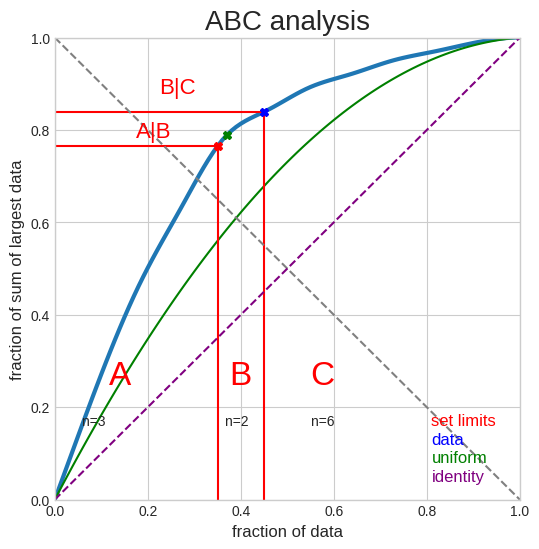

In [9]:
import abc_analysis
from abc_analysis import abc_analysis, abc_plot

# Perform an ABC analysis with plotting
dctAnalysis = abc_analysis([1, 15, 25, 17, 2, 3, 5, 6, 2, 3, 22], True)

## 2. Demand Volume segments (example)

In [10]:
import pandas as pd
import numpy as np

ts_retail = pd.read_csv(
    'https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_2products.csv',
    sep=';'
)

ts_retail['Date'] = pd.to_datetime(
    ts_retail['Date'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

ts_retail = ts_retail[ts_retail['Date'].notna()]
ts_retail.set_index('Date', inplace=True)

ts_id_columns = ['Store_id', 'SKU_id']

ts_retail.head()


,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,NaN,22.0,163.78,NaN
2015-01-02,1,1,NaN,41.0,163.78,NaN
2015-01-03,1,1,NaN,35.0,163.78,NaN
2015-01-04,1,1,NaN,72.0,163.78,NaN
2015-01-05,1,1,NaN,25.0,163.78,NaN


In [11]:
# 1.1

# считаем общий объём спроса
volume = (
    ts_retail
    .groupby(ts_id_columns)['Demand']
    .sum()
    .reset_index(name='total_demand')
)

# сортируем по убыванию и считаем кумулятивную долю
volume = volume.sort_values('total_demand', ascending=False)
total = volume['total_demand'].sum()
volume['cum_share'] = volume['total_demand'].cumsum() / total

def volume_group(row):
    if row['cum_share'] <= 0.80:
        return 'High volume (A)'
    elif row['cum_share'] <= 0.95:
        return 'Medium volume (B)'
    else:
        return 'Low volume (C)'

volume['volume_group'] = volume.apply(volume_group, axis=1)

display(volume.head())
print(volume['volume_group'].value_counts())


,Store_id,SKU_id,total_demand,cum_share,volume_group
66,34,1,551529.0,0.032863,High volume (A)
100,51,1,459249.0,0.060228,High volume (A)
30,16,1,321899.0,0.079409,High volume (A)
2,2,1,317508.0,0.098328,High volume (A)
46,24,1,316468.0,0.117185,High volume (A)


volume_group
Low volume (C)       128
High volume (A)       61
Medium volume (B)     31
Name: count, dtype: int64


In [12]:
# присоединяем группы к исходным данным
ts_retail = ts_retail.merge(
    volume[ts_id_columns + ['volume_group']],
    on=ts_id_columns,
    how='left'
)

ts_retail.head()


,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,volume_group
0,1,1,NaN,22.0,163.78,NaN,High volume (A)
1,1,1,NaN,41.0,163.78,NaN,High volume (A)
2,1,1,NaN,35.0,163.78,NaN,High volume (A)
3,1,1,NaN,72.0,163.78,NaN,High volume (A)
4,1,1,NaN,25.0,163.78,NaN,High volume (A)


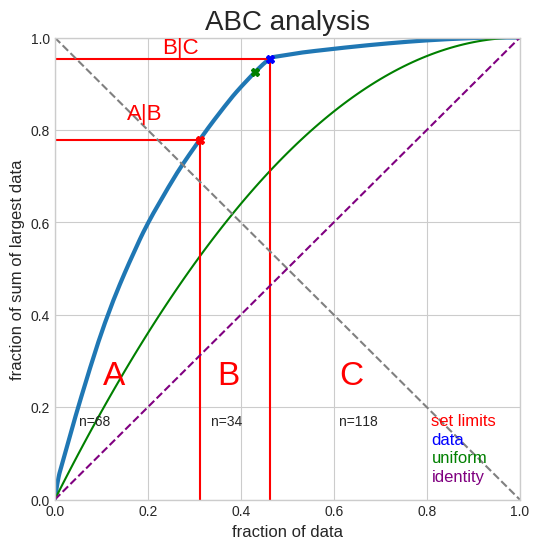

In [13]:
# split TS by Demand Volume
ts_mean_values = ts_retail.groupby(ts_id_columns)['Demand'].mean()

# Plot saved results of an ABC analysis
ts_demand_abc  = abc_analysis(ts_mean_values.fillna(0), True)


## 3. Demand Variability Segments (example)

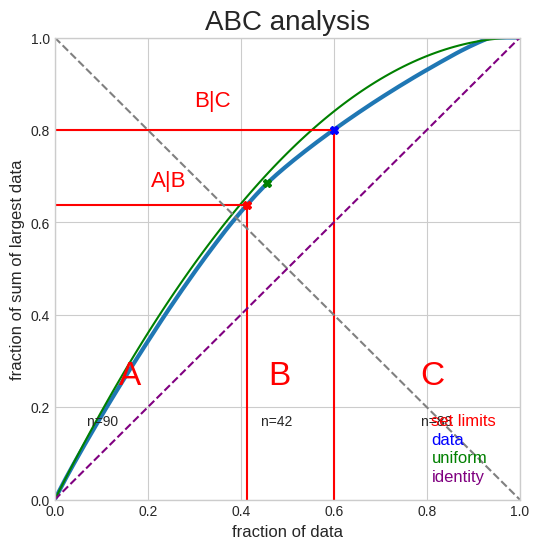

In [14]:
# split TS by Coefficient of Volatility (CV)
ts_cv_values = ts_retail.groupby(ts_id_columns)['Demand'].std().fillna(0).div(ts_retail.groupby(ts_id_columns)['Demand'].mean().fillna(1))

# Plot saved results of an ABC analysis
ts_demand_abc  = abc_analysis(ts_cv_values.fillna(0), True)

In [15]:
# 1.2

# считаем средний спрос и стандартное отклонение
stats = (
    ts_retail
    .groupby(ts_id_columns)['Demand']
    .agg(mean_demand='mean', std_demand='std')
    .reset_index()
)

# коэффициент вариации
stats['cv'] = stats['std_demand'] / stats['mean_demand']

# обработка бесконечностей и NaN
stats['cv'] = stats['cv'].replace([np.inf, -np.inf], np.nan)
stats['cv'] = stats['cv'].fillna(0)

# пороги квантилей для 3 групп
q1 = stats['cv'].quantile(1/3)
q2 = stats['cv'].quantile(2/3)
print('CV quantiles:', q1, q2)

def variability_group(cv):
    if cv <= q1:
        return 'Low variability'
    elif cv <= q2:
        return 'Medium variability'
    else:
        return 'High variability'

stats['variability_group'] = stats['cv'].apply(variability_group)

display(stats.head())
print(stats['variability_group'].value_counts())


CV quantiles: 1.022596048049063 2.04183364727627


,Store_id,SKU_id,mean_demand,std_demand,cv,variability_group
0,1,1,260.531496,315.706729,1.211780,Medium variability
1,1,2,14.726378,36.494656,2.478183,High variability
2,2,1,625.015748,536.379660,0.858186,Low variability
3,2,2,19.470472,46.053407,2.365295,High variability
4,3,1,378.708661,401.544211,1.060298,Medium variability


variability_group
Low variability       74
Medium variability    73
High variability      73
Name: count, dtype: int64


In [16]:
# присоединяем признаки вариативности к данным
ts_retail = ts_retail.merge(
    stats[ts_id_columns + ['cv', 'variability_group']],
    on=ts_id_columns,
    how='left'
)

ts_retail.head()


,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,volume_group,cv,variability_group
0,1,1,NaN,22.0,163.78,NaN,High volume (A),1.21178,Medium variability
1,1,1,NaN,41.0,163.78,NaN,High volume (A),1.21178,Medium variability
2,1,1,NaN,35.0,163.78,NaN,High volume (A),1.21178,Medium variability
3,1,1,NaN,72.0,163.78,NaN,High volume (A),1.21178,Medium variability
4,1,1,NaN,25.0,163.78,NaN,High volume (A),1.21178,Medium variability


## 4. Intermittent Demand Time Series model

$$ y_t = x_t\cdot z_t +\varepsilon_t$$

   - $x_t$ - random variable (1 or 0) to have non-zero actual value       
   - $z_t$ - actual volume


**Note:**
 - sometimes intermittent time series are classified to more classes https://frepple.com/blog/demand-classification/
 - don't confuse intermittent and highly-causal driven time series:
     -- we don't know time

### Croston Model
<img src = "https://github.com/aromanenko/ATSF/blob/main/pic/CrostonIdea.PNG?raw=true">

**Croston Algorithm for Time Series Forecasting**

$$ \hat{y}_{t+1}=\hat z_t/\hat{n}_t$$
where
$$ \hat z_t = \begin{cases}z_{t-1}, & y_t==0 \\ \alpha\cdot{y_t}+(1-\alpha) z_{t-1}, & y_t <>0 \end{cases}$$

$$ \hat{n}_t = \begin{cases}\hat{n}_t, & y_t==0 \\ \beta\cdot{\color{red}{n_t}}+(1-\beta) \hat{n}_{t-1}, & y_t <>0 \end{cases}$$

$\alpha$ - smoothing parameter for time level value
$\beta$ - smoothing parameter for 0-intervals length forecasting

<img src = "https://github.com/aromanenko/ATSF/blob/main/pic/CrostonIdea2.PNG?raw=true">


**Example of Realization**
- https://towardsdatascience.com/croston-forecast-model-for-intermittent-demand-360287a17f5f

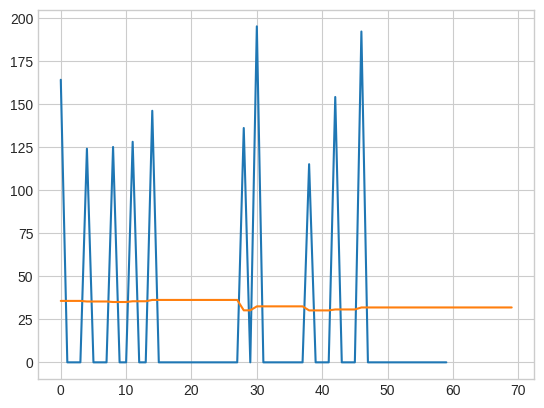

In [17]:
!pip install croston
from croston import croston
import random

a = np.zeros(50)
val = np.array(random.sample(range(100,200), 10))
idxs = random.sample(range(50), 10)

ts = np.insert(a, idxs, val)

fit_pred = croston.fit_croston(ts, 10,'original')

yhat = np.concatenate([fit_pred['croston_fittedvalues'], fit_pred['croston_forecast']])

plt.plot(ts)
plt.plot(yhat)


Times Series with intermittent-demand-pattern contains non-zero actual values in random time points (non-zero actual values occur occasionaly).


<img src = "https://github.com/aromanenko/ATSF/blob/main/pic/IntermittentExample.PNG?raw=true">
<img src = "https://github.com/aromanenko/ATSF/blob/main/pic/IntermittentExample2.PNG?raw=true">